## 다중 분류, iris

In [1]:
# 실행 런타임(CPU/GPU) 확인후 설치, 세션 초기화되면 재설치, GPU
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 보안 문제로 ipynb 파일 open시마다 실행
# from google.colab import drive
# drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/iris' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [3]:
df = pd.read_csv('./iris.csv', names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"])
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


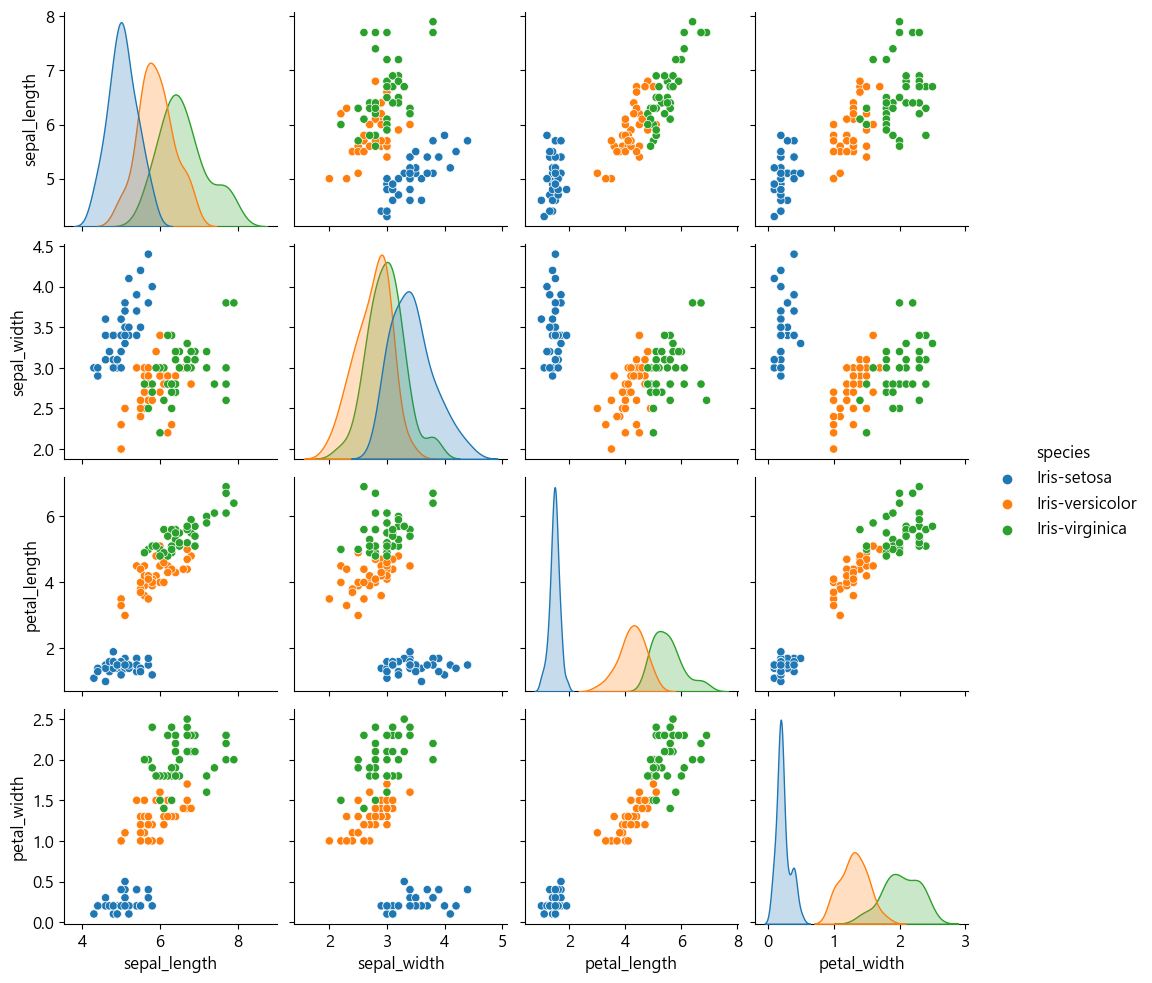

In [4]:
sb.pairplot(df, hue='species') # hue: 카테고리 변수의 품종별 색상 작동 적용 
plt.show()

In [5]:
data = df.values # Pandas -> Numpy array
print(type(data))
print(len(data))
print(data.shape)
X = data[:, 0:4].astype(float)  # 독립 변수 4개
Y_str = data[:, 4]              # 종속 변수, 5번째, 답
print(Y_str)

<class 'numpy.ndarray'>
120
(120, 5)
['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versi

In [6]:
# 문자 레이블을 숫자화, 문자열을 알파벳 순으로 0부터 부여
encoder = LabelEncoder()
# encoder.fit(Y_str) # 초기화
Y = encoder.fit_transform(Y_str)
print(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]


In [7]:
print(encoder.inverse_transform([0, 1, 2])) # Label 확인

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [8]:
# 품종이 3가지인경우 그 품종에 속할 확률도 3가지가 출력됨.
# 품종이 10만가지이면 그 품종에 속할 확률도 0 ~ 1 사이의 값으로
# 10만가지가 출력됨.

# 머신러닝에서는 종류의 갯수만큼 출력 갯수가 선언되어야함.
# LabelEncoder에 의해서 vector화된 값
# Iris-setosa       0
# Iris-versicolor   1
# Iris-virginica    2

# one-hot-encoding, 값의 종류를 자동으로 파악한후, 값에 해당하는 위치를 1로 변경 
Y_encoded = to_categorical(Y) 
print(X[0])              # Iris-setosa  0  [5.1 3.5 1.4 0.2]
print('Y[0]:', Y[0])     # Y[0]의 값 0은 1 이 위치할 index로 사용 ★

# 폼종의 갯수가 3개임으로 [1. 0. 0.], 10만개이면 1또는 0이 10만개가됨
# 희소 행렬(sparse matrix)
print('0 ->', Y_encoded[0]) 
# LabelEncoder에서 만들어진 정수값 0 ~ 2는 1이 위치할 index로 대응함.
# [5.1 3.5 1.4 0.2]는 [1. 0. 0.]으로 출력되어야 함

[5.1 3.5 1.4 0.2]
Y[0]: 0
0 -> [1. 0. 0.]


In [9]:
# Iris-setosa       0
# Iris-versicolor   1
# Iris-virginica    2
print(X[1], '->', Y[1], '->', Y_encoded[1])
print(X[2], '->', Y[2], '->', Y_encoded[2])
print(X[50], '->', Y[50], '->', Y_encoded[50])   # 1은 1이 위치할 index로 사용
print(X[100], '->', Y[100], '->', Y_encoded[100])# 2는 1이 위치할 index로 사용

[4.9 3.  1.4 0.2] -> 0 -> [1. 0. 0.]
[4.7 3.2 1.3 0.2] -> 0 -> [1. 0. 0.]
[5.9 3.2 4.8 1.8] -> 1 -> [0. 1. 0.]
[7.4 2.8 6.1 1.9] -> 2 -> [0. 0. 1.]


In [10]:
print(X.shape)
print(Y.shape)
print(Y_encoded.shape)
print(Y_encoded[0:120])
# 5.1,3.5,1.4,0.2 --> Iris-setosa --> 1. 0. 0.

(120, 4)
(120,)
(120, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0

In [11]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기, 10%: 테스트
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y_encoded,
                                                        stratify=Y_encoded,
                                                        test_size=0.1,
                                                        random_state=seed)
# 나머지 데이터 90%를 분할, 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=seed)

print(y_val)
print(y_val.shape)
# Iris-setosa: 0, Iris-versicolor: 1, Iris-virginica: 2

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
(22, 3)


In [12]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed, 가중치, 편향이 일정하게 변경됨
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Dense(20, input_dim=4, activation='relu')) # 기울기 소실 방지
model.add(Dense(10, activation='relu')) # 기울기 소실 방지
model.add(Dense(3, activation='softmax')) # 0 ~ 1사이의 확률, 합 1
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

es= EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

mcp= ModelCheckpoint(filepath='./Iris.h5', monitor='val_accuracy',
                    verbose=1, save_best_only=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True,
                epochs=1000, batch_size=1, callbacks=[es, mcp])
end=time.time()
print('Runtime: {0:.0f} 초'.format(end-start))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


46/86 [===============>..............] - ETA: 0s - loss: 1.1076 - accuracy: 0.4130     
Epoch 1: val_accuracy improved from -inf to 0.68182, saving model to .\Iris.h5
86/86 [==============================] - 1s 3ms/step - loss: 0.9521 - accuracy: 0.5465 - val_loss: 0.7289 - val_accuracy: 0.6818
Epoch 2/1000
50/86 [================>.............] - ETA: 0s - loss: 0.7036 - accuracy: 0.6800    
Epoch 2: val_accuracy did not improve from 0.68182
86/86 [==============================] - 0s 1ms/step - loss: 0.6751 - accuracy: 0.6628 - val_loss: 0.5937 - val_accuracy: 0.6818
Epoch 3/1000
56/86 [==================>...........] - ETA: 0s - loss: 0.5476 - accuracy: 0.7143
Epoch 3: val_accuracy improved from 0.68182 to 0.95455, saving model to .\Iris.h5
86/86 [==============================] - 0s 2ms/step - loss: 0.5631 - accuracy: 0.7093 - val_loss: 0.5179 - val_accuracy: 0.9545
Epoch 4/1000
79/86 [==========================>...] - ETA: 0s - loss: 0.4893 - accuracy: 0.7975
Epoch 4: val_accuracy

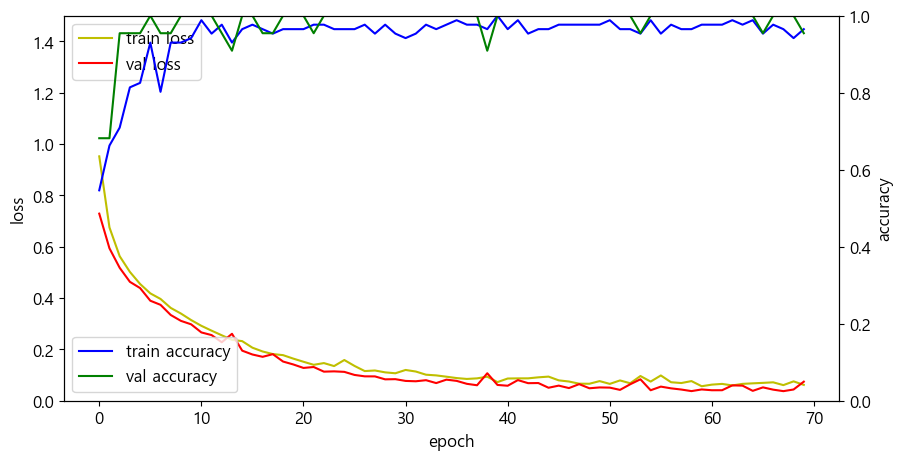

In [13]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()   # 오른쪽 y 축 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [14]:
# verbose=0: 처리과정의 메시지 생략
test_loss, test_acc = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.04393160715699196 /정확도: 100.0 %


In [15]:
model = load_model('./Iris.h5')

In [16]:
# Iris-setosa: 0, Iris-versicolor: 1, Iris-virginica: 2
print('데이터:', x_test.shape) # 변수 4개 12건
p = model.predict(x_test)     # 테스트 데이터는 12건이고 3가지 확률에 속함.
print('p.shape:', p.shape)    # (12, 3): 3: 폼종의 갯수
print('데이터:', x_test[0])   # 첫번째 데이터행

데이터: (12, 4)
p.shape: (12, 3)
데이터: [6.  2.2 5.  1.5]


In [17]:
print('예측값:', p[0])       # 확률 0 ~ 1사이의 실수값
print('예측값의 합: {0:0.3f}'.format(np.sum(p[0])))
print('예측값: {0:.5f}% {1:.5f}% {2:.5f}%'.format(p[0,0]*100,p[0,1]*100,p[0,2]*100))
print('One-hot-encoding: ', y_test[0])
print(np.argmax(p[0]))      # 가장 큰값의 index
# class 출력안됨.

# 실제 데이터: 6.  2.2 5.  1.5
# 답(Target) : 0    0    1 
# 예측값: [0.12629476 0.3950674  0.4786379 ] 
# 학습을하면서 [0  0  1] 과의 오차를 계산하면서 근사
# (출력 결과가 target의 값에 가까워 지는것)
# 정답에 근사되도록 가중치와 편향을 변경(미분)한다.

예측값: [0.01545686 0.35216865 0.63237447]
예측값의 합: 1.000
예측값: 1.54569% 35.21686% 63.23745%
One-hot-encoding:  [0. 0. 1.]
2


In [18]:
print(p)
# Iris-setosa: 0, Iris-versicolor: 1, Iris-virginica: 2

[[0.01545686 0.35216865 0.63237447]
 [0.01236897 0.3385591  0.64907193]
 [0.00889411 0.37906227 0.6120437 ]
 [0.95659554 0.00344513 0.03995939]
 [0.02516274 0.5226651  0.45217222]
 [0.0149844  0.39131692 0.5936987 ]
 [0.9109701  0.01449961 0.07453021]
 [0.01718527 0.4664848  0.51632994]
 [0.03786755 0.5502883  0.4118441 ]
 [0.922328   0.01122466 0.0664473 ]
 [0.0128906  0.43580776 0.55130166]
 [0.9529624  0.00470011 0.04233757]]
